In [ ]:
from granulation_fitting import scalingRelations
import pandas as pd
import numpy as np
import jax.numpy as jnp
import corner
import scipy.stats as st
from matplotlib.pyplot import *
from DR import PCA
import utils
import sklearn.ensemble as skl

In [ ]:
df = pd.read_csv('/home/nielsemb/work/mounts/Bluebear_projects/granulation/bkgfig_output.csv')
print(len(df))
df.dropna(axis=0, how="any", inplace=True)

In [ ]:
df.keys()

In [ ]:
idx = df.loc[:, 'completed'] == 1
print(len(df[idx]))

In [ ]:
def plotScatter(samples, keys, c=None, indx=None):
    
    if indx is None:
        indx = np.zeros(samples.shape[0], dtype=bool)
    
    N = len(keys)
    
    fig, ax = subplots(N, N , figsize=(20,20))

    for i in range(N):
     
        for j in range(N):

            xdata = samples[keys[j]]
            if 'exp' in keys[j]:
                xdata = 10**xdata

            ydata = samples[keys[i]]
            if 'exp' in keys[i]:
                ydata = 10**ydata

            xlims = np.nanpercentile(xdata, [0.001, 99.999])
             
            ylims = np.nanpercentile(ydata, [0.001, 99.999])

            if i == j:

                
                y_in = ydata[~indx]

                K = st.gaussian_kde(y_in[~np.isnan(y_in)], bw_method=0.15)

                _x = np.linspace(xlims[0], xlims[1], 200)

                ax[i, j].plot(_x, K(_x), color='C0')

                ax[i, j].fill_between(_x, K(_x), color='C0', alpha=1)
                
                y_out = ydata[indx]
                 
                if len(y_out) > 0:
                    K = st.gaussian_kde(y_out[~np.isnan(y_out)], bw_method=0.15)

                    _x = np.linspace(xlims[0], xlims[1], 200)

                    ax[i, j].plot(_x, K(_x), color='C1')

                    ax[i, j].fill_between(_x, K(_x), color='C1', alpha=0.5)
    
                ax[i, j].set_yticks([])

                ax[i, j].set_xlim(xlims[0], xlims[1])

                #ax[i, j].set_ylim(0, max(K(_x))*1.1)

            elif i > j:

                ax[i, j].scatter(xdata[~indx], ydata[~indx], s=10, alpha=0.5, c=c)

                # Plot outliers if any
                if indx is not None:
                    ax[i, j].scatter(xdata[indx], ydata[indx], s=20, alpha=1, color='C1')

                ax[i, j].set_xlim(xlims[0], xlims[1])

                ax[i, j].set_ylim(ylims[0], ylims[1])

            else:
                ax[i, j].axis('off')


            if i < N-1:
                ax[i, j].set_xticks([])

            if (j > 0) & (j < N-1):
                ax[i, j].set_yticks([])


            if (i == N-1):
                ax[i, j].set_xlabel(keys[j])

            if (i > 0) and (j == 0):
                    ax[i, j].set_ylabel(keys[i])
            
    fig.tight_layout()

    return fig, ax

fig, ax = plotScatter(df, ['H1_power', 'H1_nu', 'H1_exp', 'shot']);


In [ ]:

nyq_idx = df['numax'] < np.log10(1/(2*1800) * 1e6)

variable_keys = ['bkg_numax', 'bkg_envWidth', 'bkg_envHeight',
                 'H1_power', 'H1_nu', 'H1_exp',
                 'H2_power', 'H2_nu', 'H2_exp']

pre_outlier_keys = [key+'_err' for key in variable_keys]

def findOutliers(df, keys=None, contamination=0.03, max_features=None):
    
    if keys is None:
        keys = df.keys()
    
    if max_features is None:
        max_features = 1
        
    X = df[keys].values

    clf = skl.IsolationForest(contamination=contamination, max_features=max_features).fit(X)

    outliers = clf.predict(X) < 1

    return outliers

def line(x, a, b):
    return a*x+b

In [ ]:
def applyLinearCuts(df):
    
    numaxoutliers = np.invert((line(df['numax'], 1, -0.06) < df['bkg_numax']) & (df['bkg_numax'] < line(df['numax'], 1, 0.03)))
    
    widthoutliers = np.invert(df['bkg_envWidth'] > line(df['bkg_numax'], 0.85, - 1.4))
    
    H2_outliers = np.invert((df['H2_nu'] > line(df['bkg_numax'], 1, -0.9)) & (df['H2_nu'] < line(df['bkg_numax'], 1, - 0.3)))

    H1_outliers = np.invert(df['H1_nu'] > line(df['bkg_numax'], 1, -0.3))
    
    envHeight_outliers = np.invert(df['bkg_envHeight'] > 1)
    
    return numaxoutliers | widthoutliers | H2_outliers | H1_outliers | envHeight_outliers

prec_outliers = findOutliers(df[nyq_idx], pre_outlier_keys)

D = df[nyq_idx][~prec_outliers].append(df[~nyq_idx])

linear_outliers = applyLinearCuts(D)

# idx = linear_outliers

 
# x = df['H1_nu']
# y = line(x, 8, -13.3)
# ax[1, 0].plot(x, y)

In [ ]:
PCAkeys = ['ID', 'bkg_numax', 'bkg_envHeight', 'bkg_envWidth', 
                 'H1_power', 'H1_nu', 'H1_exp', 
                 'H2_power', 'H2_nu', 'H2_exp']

fig, ax = plotScatter(D[~linear_outliers], PCAkeys[1:]);

In [ ]:
D.loc[~linear_outliers, PCAkeys].to_csv('PCAsample.csv', index=False)

In [ ]:
hist(D.loc[~linear_outliers, 'bkg_numax'], bins = np.linspace(2.25, 2.8, 30))

In [ ]:
pdf = pd.read_csv('/home/nielsemb/work/mounts/Bluebear_projects/granulation/bkgfig_output.csv')

for i in pdf.index:
    if pdf.loc[i, 'ID'] in D[~linear_outliers]['ID'].values:
        pdf.drop(index=i, inplace=True)

In [ ]:
pdf.to_csv('outlier_run.csv', index = False)

In [ ]:
def wfunc(x, pdf, n=1):
    
    w = 1/pdf(x)**n
       
    return w

ppf, pdf = P.getQuantileFuncs(P.data_F[:, :1])
weights = wfunc(P.data_F[:, 0], pdf[0], n=4)

In [ ]:
P_test = PCA(numax_guess, pcalabels, weights=weights, N=20)
P_test.fit_weightedPCA(2)

In [ ]:
P.makeTrainingCorner()
P_test.makeTrainingCorner()

In [ ]:
import statsmodels.api as sm
import numpy as np
import utils
import jax.numpy as jnp
import pandas as pd

def getQuantileFuncs(data):
    """

    Estimate quantile function for a distribution of points, based on the
    univariate KDE of the points.

    """

    ppfs = []

    pdfs = []

    for i in range(data.shape[1]):

        kde = sm.nonparametric.KDEUnivariate(np.array(data[:, i]).real)

        kde.fit(adjust=2)

        Q = kde.icdf

        A = jnp.linspace(0, 1, len(Q))

        ppfs.append(utils.jaxInterp1D(A, Q))

        pdfs.append(kde.evaluate)

    return ppfs, pdfs

In [ ]:
df = pd.read_csv('/home/nielsemb/work/mounts/Bluebear_projects/granulation/bkgfig_output.csv')


In [ ]:
idx = (df['numax'].values > 2.25) & (df['numax'].values < 2.5)
ppfs, pdfs = getQuantileFuncs(df[['numax', 'bkg_numax']].values[idx])

In [ ]:
pdfs

In [ ]:
from matplotlib.pyplot import *
hist(df['numax'].values[idx], bins=30, log=True, density=True)
x = np.linspace(ppfs[0](0), ppfs[0](1), 100)
plot(x, pdfs[0](x))

In [ ]:
x

In [ ]:
ppfs[0](-1)

In [184]:
from DR import PCA
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import utils
import scipy.special as sc

nsigma=4
percentiles = [0.5 - sc.erf(n/np.sqrt(2))/2 for n in range(-nsigma, nsigma+1)][::-1]
 
df = pd.read_csv('/home/nielsemb/work/repos/granulation/PCAsample.csv')

#df = pd.read_csv('/home/nielsemb/work/mounts/Bluebear_projects/granulation/bkgfig_output.csv')
pcalabels = ['bkg_numax', 'bkg_envHeight', 'bkg_envWidth',
             'H1_power', 'H1_nu', 'H1_exp',
             'H2_power', 'H2_nu', 'H2_exp',]

K = 30

Ns = np.array([100, 200, 400, 800])

test_numaxs = np.log10(np.linspace(10**min(df['bkg_numax']), 10**max(df['bkg_numax']), K)) # np.linspace(min(df['bkg_numax']), max(df['bkg_numax']), K)

varR = np.zeros((len(Ns), K, 9))
 
B = np.zeros((len(Ns), K))

#fig, axes = subplots(len(Ns), K, figsize=(20,20))

for j, N in enumerate(Ns):
    for i, numax in enumerate(test_numaxs):
        
        _numax = utils.to_log10((10**numax), 0.20*(10**numax))
        
        
        P = PCA(_numax, pcalabels, N=N)

        P.fit_weightedPCA(9)

        varR[j, i, :] = np.array(P.explained_variance_ratio).real

        ppfs, pdfs = P.getQuantileFuncs(P.data_F)


        x = np.linspace(ppfs[0](0), ppfs[0](1), 1000)
        y = pdfs[0](x)

        percs = utils.getCurvePercentiles(x, y, percentiles)

        Percs = np.append(-np.inf, np.append(percs, np.inf))

        idx = [(Percs[i] <= numax) & (numax <= Percs[i+1]) for i in range(len(Percs)-1)] 
        
        b = np.arange(2*nsigma + 2)[idx]
        
        if (len(b) > 1) & (numax > Percs[len(Percs)//2]):
            B[j, i] = b[0]
        elif (len(b) > 1) & (numax < Percs[len(Percs)//2]):
            B[j, i] = b[-1]
#         elif len(b) == 0:
#             b = -np.inf
        else:
            B[j, i] = b
            
#         axes[j, i].plot(x, y)
#         axes[j, i].axvline(numax, color = 'k', ls='dashed')
#         axes[j, i].hist(df['bkg_numax'], bins=np.linspace(min(df['bkg_numax']), max(df['bkg_numax']), 50), log=True)
#         axes[j, i].hist(P.data_F[:, 0], bins=np.linspace(min(df['bkg_numax']), max(df['bkg_numax']), 50), log=True)      

/home/nielsemb/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


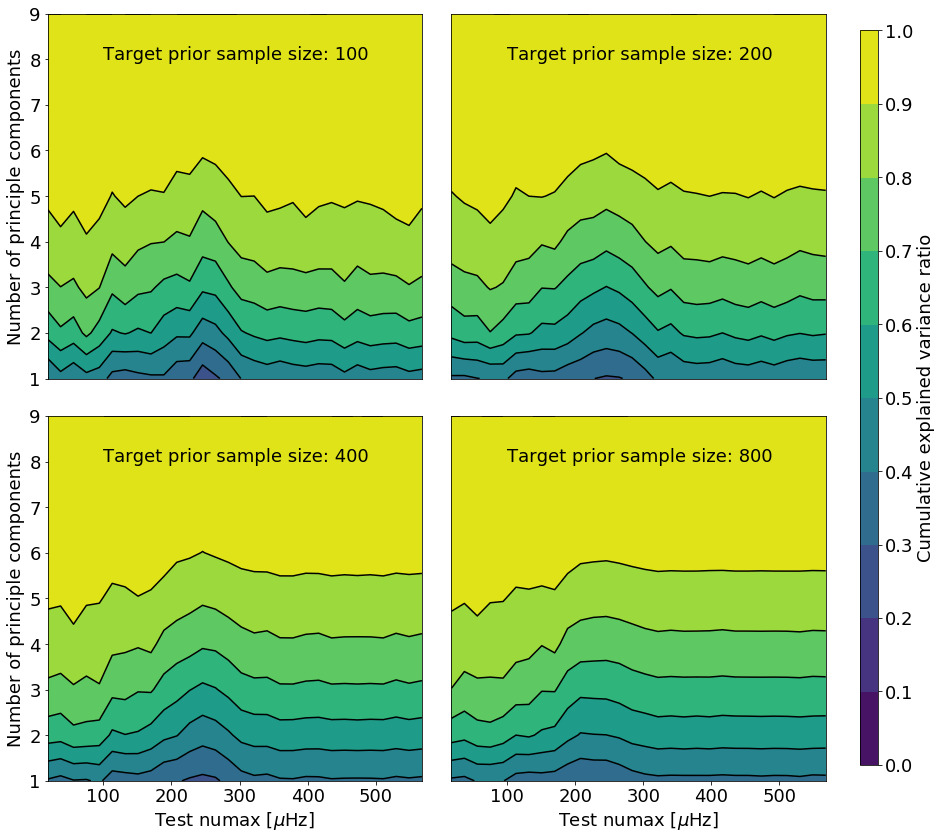

In [211]:
rcParams['font.size'] = 18

fig, axes = subplots(2,2,figsize=(12,12))
lvls = np.linspace(0, 1, 11)

for j, ax in enumerate(axes.flatten()): 
    cvarR =   np.cumsum(varR[j, :, :], axis = 1)  

    cl = ax.contourf(10**test_numaxs, np.arange(1,10), cvarR.T, levels=lvls)
    
    ax.contour(10**test_numaxs, np.arange(1,10), cvarR.T, levels=lvls, colors='k')

    ax.set_xlabel('Test numax [$\mu$Hz]')
    ax.set_ylabel('Number of principle components')
    
    ax.text(x=100, y=8, s=f'Target prior sample size: {Ns[j]}')
     
    if j in [1,3]:
        ax.set_ylabel(None)
        ax.set_yticks([])
        
    if j in [0,1]:
        ax.set_xlabel(None)
        ax.set_xticks([])
        
cb_ax = fig.add_axes([1.01, 0.1, 0.02, 0.85])
cbar = fig.colorbar(cl, cax=cb_ax, label='Cumulative explained variance ratio')

# set the colorbar ticks and tick labels
cbar.set_ticks(lvls)
#cbar.set_ticklabels(['low', 'medium', 'high'])

fig.tight_layout()

Text(0, 0.5, 'Prior sample size')

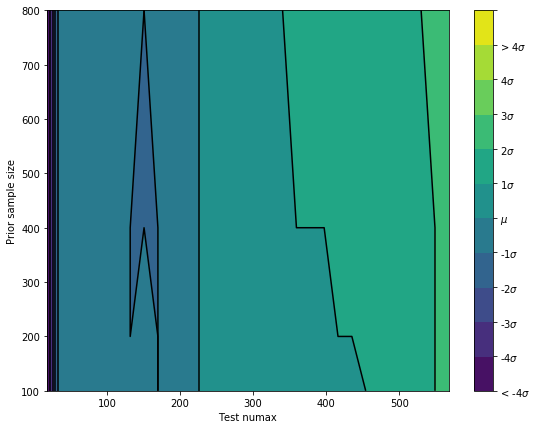

In [188]:
fig, ax = subplots(figsize=(9,7))
lvls = np.arange(len(Percs)+1)

 
cl = ax.contourf(10**test_numaxs, Ns, B, levels=lvls )
ax.contour(10**test_numaxs, Ns, B, colors='k', levels=lvls)
cbar = fig.colorbar(cl, ticks=lvls)
lbls = ['%i$\sigma$' % (n) for n in np.arange(len(Percs))-len(Percs)//2]
lbls[0] = '< %i$\sigma$' % (np.arange(len(Percs))[1]-len(Percs)//2)
lbls[len(Percs)//2] = '$\mu$'
lbls[-1] = '> %i$\sigma$' % (np.arange(len(Percs))[-2]-len(Percs)//2)
cbar.ax.set_yticklabels(lbls)

ax.set_xlabel('Test numax')
ax.set_ylabel('Prior sample size')